In [2]:
using Luxor
using Plots
using Base

In [211]:
REWARDS = zeros(Int16,10,10)
ABSORB_STATES = [[8,9],[3,8],[4,8],[5,8]]
REWARDS[8,9] = 10
REWARDS[3,8] = 3
REWARDS[4,8] = 3
REWARDS[5,8] = 3
REWARDS[5,4] = -5
REWARDS[8,4] = -10
REWARDS[8,7] = -10
REWARDS

10×10 Array{Int16,2}:
 0  0  0    0  0  0    0  0   0  0
 0  0  0    0  0  0    0  0   0  0
 0  0  0    0  0  0    0  3   0  0
 0  0  0    0  0  0    0  3   0  0
 0  0  0   -5  0  0    0  3   0  0
 0  0  0    0  0  0    0  0   0  0
 0  0  0    0  0  0    0  0   0  0
 0  0  0  -10  0  0  -10  0  10  0
 0  0  0    0  0  0    0  0   0  0
 0  0  0    0  0  0    0  0   0  0

In [135]:
function R(s,a)
    global REWARDS
    r = REWARDS[s...]
    
    if a=="U" && s[1] == 1
        r -= 1
    elseif a=="D" && s[1] == 10
        r -= 1
    elseif a=="L" && s[2] == 1
        r -= 1
    elseif a=="R" && s[2] == 10
        r -= 1
    end
        
    return r
end


function S(s,a=nothing)
    ALL_MOVES = [[s[1]-1,s[2]], # UP
                [s[1]+1,s[2]], # DOWN
                [s[1],s[2]-1], # LEFT
                [s[1],s[2]+1]] # RIGHT
    
    return filter(x->x[1]∈1:10 && x[2]∈1:10,ALL_MOVES)
end


function T(s′,s,a)
    pos_prob = 0.7
    
    diff = s′-s
    
    t = (1-pos_prob)/3
    
    if diff == [-1,0] && a=="U"
        t = pos_prob
    elseif diff == [1,0] && a=="D"
        t = pos_prob
    elseif diff == [0,-1] && a=="L"
        t = pos_prob
    elseif diff == [0,1] && a=="R"
        t = pos_prob
    elseif diff ∉ [[-1,0],[1,0],[0,-1],[0,1]]
        t = 0
    end
    
    return t
end


function SelectAction(s,d)
    
    ACTIONS = ["U","D","L","R"];
    γ = 0.9;
    
    if d == 0
        return (nothing,0)
    end
    
    (a_star,v_star) = (nothing, -Inf)
    
    for a ∈ ACTIONS
        v = R(s,a)
        
        for s′ ∈ S(s,a)
            
            (a′,v′) = SelectAction(s′, d-1)
            v = v + γ*T(s′,s,a)*v′
        end
        
        if v > v_star
            (a_star,v_star) = (a,v)
        end
    end
    
    return  a_star,v_star
end

SelectAction (generic function with 1 method)

In [136]:
function draw_grid(grid,pos)
    size = [400,400]
    Drawing(size...)
    background("black")
    
    grid = transpose(grid)
    
    pos_n = (pos[1]-1)*10 + pos[2]
    
    tiles = Tiler(size..., 10, 10, margin=5)
    g = [:red, :white, :green]
    colors = cgrad(g)
    grid_max = max(grid...)
    grid_min = min(grid...)
    for (pos, n) in tiles
        box(pos+Point(size/2...), tiles.tilewidth*0.95, tiles.tileheight*0.95, :clip)
        intensity = (grid[n]-grid_min)/(grid_max-grid_min)
        background(colors[intensity])
        
        
        sethue("black")
        textcentred(string(grid[n]), pos+Point(size/2...))
        
        if n == pos_n
            sethue("purple")
            setmode("darken")
            circle(pos+Point(size/2...),20,:fill)
            setmode("over")
        end
        
        clipreset()
        
        
    end
    finish()
    preview()
end

draw_grid (generic function with 1 method)

In [137]:
function move(s,a)
    rng = rand()
    ACTIONS = ["U","D","L","R"]
    
    
    if rng > 0.7
        a = rand(filter(x->x≠a,ACTIONS))
    end
    
    r = R(s,a)
    
    if a == "U" && s[1] ≠ 1
        s[1] -= 1
    elseif a == "D" && s[1] ≠ 9
        s[1] += 1
    elseif a == "L" && s[2] ≠ 1
        s[2] -= 1
    elseif a == "R" && s[2] ≠ 9
        s[2] += 1
    end
    
    return s,r
end

move (generic function with 1 method)

# Trapped in Local Maxima
- Agent Position denoted by purple circle
- Using depth of 5 provides reasonably fast computation time
    - However, having positive rewards outside of 5 move range causes agent to continuously avoid negative rewards as opposed to seeking out the positive rewards
        - Notice agent tends to upper left corner, maintaining a safe distance from edge bump penalty and -5 reward

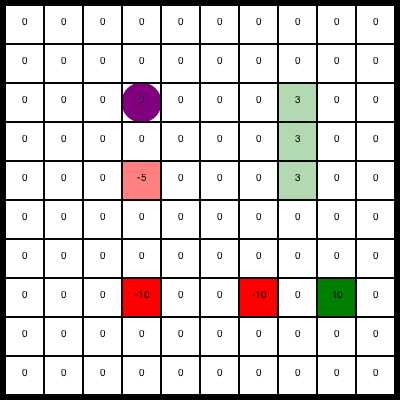

In [212]:
# RESET/INITIALIZE
s = [3,4];
score = 0;
d = 4;
draw_grid(REWARDS,s)

(a_star, v_star) = ("D", 0.0)
score = 0


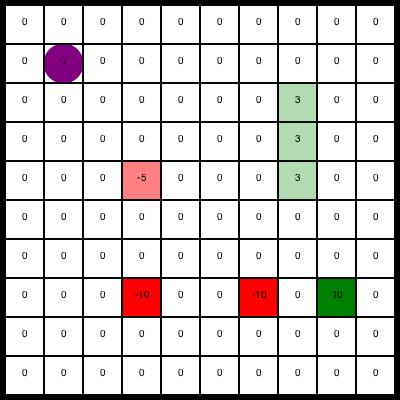

In [229]:
# Run Cell Continuously to update position
a_star, v_star = SelectAction(s,d)
@show a_star, v_star
s,r = move(s, a_star)
score += r
@show score
draw_grid(REWARDS,s)

# Preferring row of +3's over single +10
- Absorbing states not taken into account for in forward search
    - Conseqently 3x +3 rewards are valued more highly than single +10 reward
    - Result: Suboptimal return of +3 reward as opposed to the possible +10

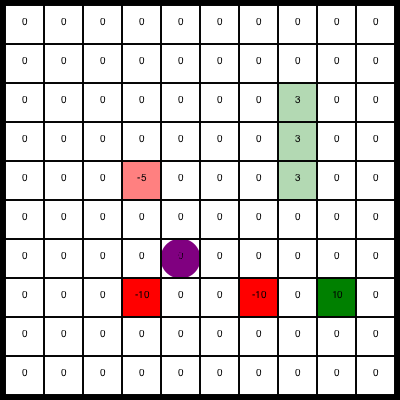

In [242]:
# RESET/INITIALIZE
s = [7,5];
score = 0;
d = 5;
draw_grid(REWARDS,s)

(a_star, v_star) = ("R", 3.98135736)
score = 0


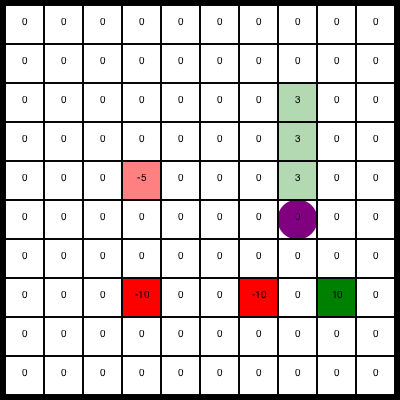

In [246]:
# Run Cell Continuously to update position
a_star, v_star = SelectAction(s,d)
@show a_star, v_star
s,r = move(s, a_star)
score += r
@show score
draw_grid(REWARDS,s)